# One-Factor and N-Factor Gaussian Copula Credit Portfolio Models

This notebook illustrates the **latent-variable interpretation** of Gaussian copula models for correlated credit defaults and applies them to credit-risky bond portfolios.

We:
- Review the one-factor Gaussian copula model.
- Simulate correlated default indicators.
- Analyse loss distributions and risk measures for simple portfolios.
- Extend to an **N‑factor model with economically meaningful factors** (Global, US, EU, EM) and a larger bond portfolio.
- Extend the Gaussian to a non-Gaussian copula model.


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)
plt.style.use('seaborn-v0_8')

## 1. One-factor Gaussian copula model

We model default of obligor $i$ over a fixed horizon $T$ via a latent standard normal variable $Z_i$:
$$
Z_i = \sqrt{\rho}\,Y + \sqrt{1-\rho}\,\varepsilon_i,
$$
where $Y$ is a common systematic factor and $\varepsilon_i$ are idiosyncratic shocks, all standard normal and independent.

Given a marginal default probability $q_i = \Pr(\tau_i \le T)$, obligor $i$ defaults by time $T$ if
$$
Z_i \le c_i := \Phi^{-1}(q_i).
$$

This is equivalent to a Gaussian copula on default times with **asset correlation** $\rho$.

In [56]:
def simulate_gaussian_copula_defaults(n_obligors, q, rho, n_paths):
    """Simulate correlated default indicators over a fixed horizon (one-factor model).

    Parameters
    ----------
    n_obligors : int
        Number of obligors.
    q : array-like, shape (n_obligors,)
        Marginal default probabilities over the horizon.
    rho : float
        Asset correlation in [0, 1).
    n_paths : int
        Number of Monte Carlo scenarios.

    Returns
    -------
    defaults : ndarray, shape (n_paths, n_obligors)
        Boolean default indicators for each path and obligor.
    """
    q = np.asarray(q)
    if q.shape[0] != n_obligors:
        raise ValueError("q must have length n_obligors")

    Y = np.random.normal(size=(n_paths, 1))
    eps = np.random.normal(size=(n_paths, n_obligors))

    Z = np.sqrt(rho) * Y + np.sqrt(1 - rho) * eps
    c = norm.ppf(q)
    defaults = Z <= c
    return defaults

## 2. Homogeneous portfolio example

Simple example:
- $n = 100$ obligors.
- Identical 1-year default probability $q = 2\%$.
- Loss-given-default (LGD) 60\%.
- Equal exposure-at-default (EAD) of 1.

We simulate the 1-year loss distribution under different asset correlations $\rho$.

In [57]:
n_obligors = 100
q = np.full(n_obligors, 0.02)
LGD = 0.60
EAD = np.full(n_obligors, 1.0)

n_paths = 100_000
rhos = [0.0, 0.2, 0.5]
loss_results = {}

for rho in rhos:
    defaults = simulate_gaussian_copula_defaults(n_obligors, q, rho, n_paths)
    losses = (defaults * (EAD * LGD)).sum(axis=1)
    loss_results[rho] = losses

### Loss distribution vs correlation

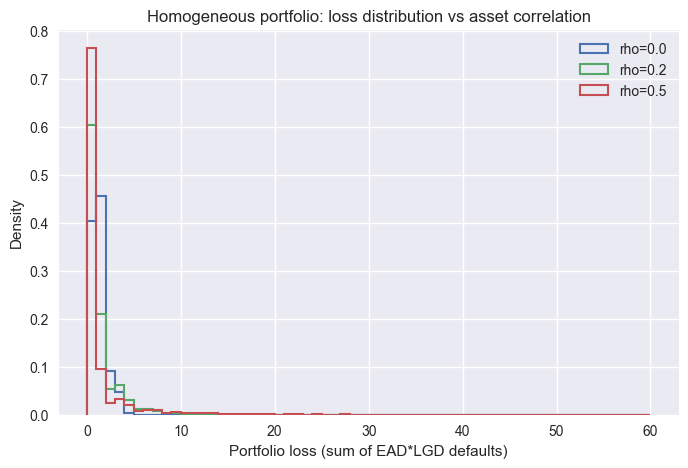

In [58]:
fig, ax = plt.subplots(figsize=(8, 5))
bins = np.arange(0, 61, 1)

for rho, losses in loss_results.items():
    ax.hist(losses, bins=bins, density=True, histtype='step', linewidth=1.5, label=f"rho={rho:.1f}")

ax.set_xlabel('Portfolio loss (sum of EAD*LGD defaults)')
ax.set_ylabel('Density')
ax.set_title('Homogeneous portfolio: loss distribution vs asset correlation')
ax.legend()
plt.show()

### Expected loss and tail risk

We compute expected loss (EL), 99% Value-at-Risk (VaR) and 99% Expected Shortfall (ES).

In [59]:
def risk_measures(losses, alpha=0.99):
    el = np.mean(losses)
    var = np.quantile(losses, alpha)
    es = losses[losses >= var].mean()
    return el, var, es

summary = []
for rho, losses in loss_results.items():
    el, var99, es99 = risk_measures(losses, 0.99)
    summary.append({"rho": rho, "EL": el, "VaR99": var99, "ES99": es99})

summary_df = pd.DataFrame(summary)
summary_df

,rho,EL,VaR99,ES99
0,0.0,1.199916,3.6,3.808835
1,0.2,1.206756,8.4,11.054167
2,0.5,1.192584,17.4,24.635329


Expected loss is essentially independent of correlation, but VaR and ES increase strongly with \(\rho\).

## 3. Heterogeneous bond portfolio (one-factor)

We now define a small portfolio of credit-risky zero-coupon bonds with different maturities and credit qualities. For each bond \(i\) we specify:
- Notional $N_i$.
- Maturity $T_i$ (years).
- Annual default probability $p_i$ (assumed constant hazard for simplicity).
- Loss-given-default $LGD_i$.

We compute the $T_i$-horizon default probability as
$$
q_i(T_i) = 1 - (1 - p_i)^{T_i}.
$$

In [60]:
bond_data = pd.DataFrame({
    'name': ['AA 2Y', 'A 3Y', 'BBB 5Y', 'BB 5Y', 'BB 7Y', 'B 7Y', 'B 10Y', 'CCC 5Y'],
    'notional': [5, 5, 10, 5, 5, 5, 5, 2],
    'maturity': [2, 3, 5, 5, 7, 7, 10, 5],
    'ann_pd': [0.001, 0.002, 0.005, 0.01, 0.015, 0.02, 0.03, 0.08],
    'LGD': [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7],
})

T_horizon = bond_data['maturity'].max()
q_T = 1 - (1 - bond_data['ann_pd']) ** bond_data['maturity']
bond_data['PD_horizon'] = q_T
bond_data

,name,notional,maturity,ann_pd,LGD,PD_horizon
0,AA 2Y,5,2,0.001,0.6,0.001999
1,A 3Y,5,3,0.002,0.6,0.005988
2,BBB 5Y,10,5,0.005,0.6,0.024751
3,BB 5Y,5,5,0.010,0.6,0.049010
4,BB 7Y,5,7,0.015,0.6,0.100391
5,B 7Y,5,7,0.020,0.6,0.131874
6,B 10Y,5,10,0.030,0.6,0.262576
7,CCC 5Y,2,5,0.080,0.7,0.340918


We assume a **single common horizon** equal to the maximum maturity (10 years). For bonds maturing earlier, default by maturity counts as a loss; after maturity there is no exposure.

Now we simulate portfolio losses for different $ho$ values.

In [61]:
n_bonds = len(bond_data)
q_vec = bond_data['PD_horizon'].values
EAD_vec = bond_data['notional'].values
LGD_vec = bond_data['LGD'].values

n_paths = 200_000
rhos2 = [0.0, 0.2, 0.5]
loss_results2 = {}

for rho in rhos2:
    defaults = simulate_gaussian_copula_defaults(n_bonds, q_vec, rho, n_paths)
    losses = (defaults * (EAD_vec * LGD_vec)).sum(axis=1)
    loss_results2[rho] = losses

### Loss distribution of the bond portfolio

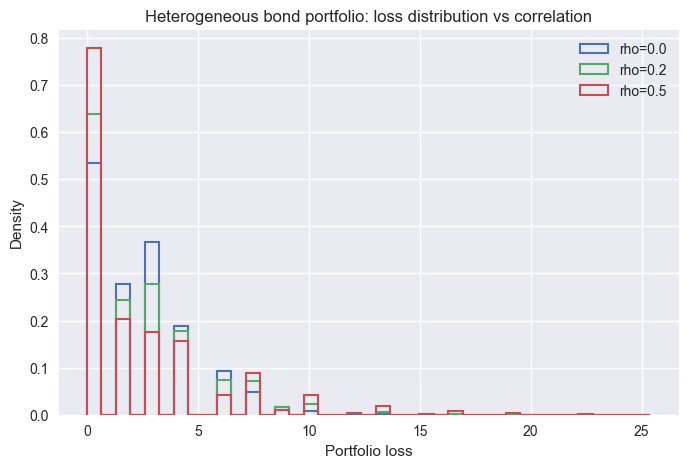

In [62]:
fig, ax = plt.subplots(figsize=(8, 5))

max_loss = (EAD_vec * LGD_vec).sum()
bins = np.linspace(0, max_loss, 40)

for rho, losses in loss_results2.items():
    ax.hist(losses, bins=bins, density=True, histtype='step', linewidth=1.5, label=f"rho={rho:.1f}")

ax.set_xlabel('Portfolio loss')
ax.set_ylabel('Density')
ax.set_title('Heterogeneous bond portfolio: loss distribution vs correlation')
ax.legend()
plt.show()

### Risk measures for the bond portfolio

In [63]:
summary2 = []
for rho, losses in loss_results2.items():
    el, var99, es99 = risk_measures(losses, 0.99)
    summary2.append({"rho": rho, "EL": el, "VaR99": var99, "ES99": es99})

pd.DataFrame(summary2)

,rho,EL,VaR99,ES99
0,0.0,2.283612,9.0,9.911808
1,0.2,2.278101,10.4,11.643260
2,0.5,2.283739,15.0,17.728876


## 4. Conditional default probabilities given the factor

In the one-factor model, conditional on the common factor $Y = y$, obligor $i$) defaults if
$$
\sqrt{\rho}\,y + \sqrt{1-\rho}\,\varepsilon_i \le c_i.
$$
The conditional default probability is
$$
\Pr(\tau_i \le T \mid Y=y) = \Phi\left(\frac{c_i - \sqrt{\rho}\,y}{\sqrt{1-\rho}}\right).
$$
We visualise how this varies with $y$ for a given obligor.

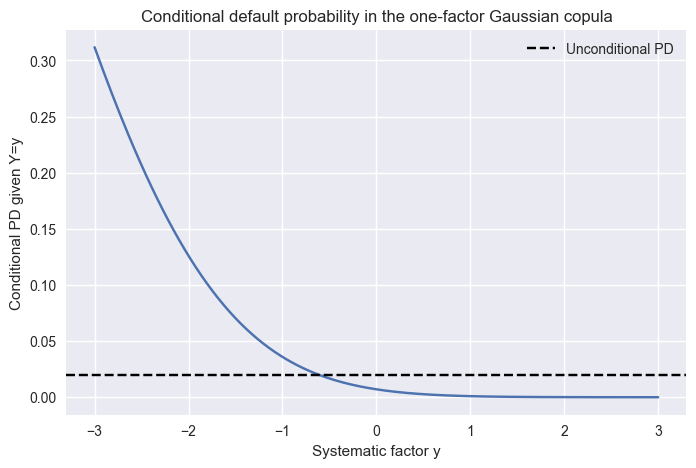

In [64]:
rho = 0.3
q_single = 0.02
c_single = norm.ppf(q_single)

y_grid = np.linspace(-3, 3, 201)
cond_pd = norm.cdf((c_single - np.sqrt(rho) * y_grid) / np.sqrt(1 - rho))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(y_grid, cond_pd)
ax.set_xlabel('Systematic factor y')
ax.set_ylabel('Conditional PD given Y=y')
ax.set_title('Conditional default probability in the one-factor Gaussian copula')
ax.axhline(q_single, color='k', linestyle='--', label='Unconditional PD')
ax.legend()
plt.show()

## 5. N-factor Gaussian copula model with economic factors

We now move to an **N‑factor** Gaussian copula with economically meaningful factors:
- Factor 0: Global cycle.
- Factor 1: US macro / credit.
- Factor 2: Euro area macro / credit.
- Factor 3: Emerging markets.

Latent variable for obligor $i$:
$$
Z_i = a_{i0} F_0 + a_{i1} F_1 + a_{i2} F_2 + a_{i3} F_3 + \sqrt{1-\Vert a_i\Vert^2}\,\varepsilon_i,
$$
where $F_k \sim N(0,1)$ are independent systematic factors, $a_i$ is the vector of factor loadings for obligor $i$, and $\varepsilon_i \sim N(0,1)$ is idiosyncratic risk. We require $\Vert a_i\Vert^2 = \sum_k a_{ik}^2 < 1$.

Default occurs if $Z_i \le c_i = \Phi^{-1}(q_i)$ as before.

This naturally produces **sector / region correlations** driven by shared global and regional factors.

In [65]:
def simulate_nfactor_gaussian_copula_defaults(q, A, n_paths):
    """Simulate correlated default indicators under an N-factor Gaussian copula.

    Parameters
    ----------
    q : array-like, shape (n_obligors,)
        Marginal default probabilities over the horizon.
    A : ndarray, shape (n_obligors, n_factors)
        Factor loadings per obligor. Each row a_i must satisfy ||a_i||^2 < 1.
    n_paths : int
        Number of Monte Carlo scenarios.

    Returns
    -------
    defaults : ndarray, shape (n_paths, n_obligors)
        Boolean default indicators.
    """
    q = np.asarray(q)
    A = np.asarray(A)
    n_obligors, n_factors = A.shape
    if q.shape[0] != n_obligors:
        raise ValueError("q length must match number of obligors")

    # Norm of each loading vector
    norm2 = np.sum(A**2, axis=1)
    if np.any(norm2 >= 1.0):
        raise ValueError("Each row of A must satisfy ||a_i||^2 < 1")

    # Systematic factors: n_paths x n_factors
    F = np.random.normal(size=(n_paths, n_factors))

    # Idiosyncratic shocks: n_paths x n_obligors
    eps = np.random.normal(size=(n_paths, n_obligors))

    # Z = F * A^T + sqrt(1 - ||a||^2) * eps
    # F @ A^T: (n_paths x n_factors) @ (n_factors x n_obligors) = (n_paths x n_obligors)
    Z_sys = F @ A.T
    idio_scale = np.sqrt(1.0 - norm2)
    Z = Z_sys + eps * idio_scale

    c = norm.ppf(q)
    defaults = Z <= c
    return defaults

### 5.1 Larger synthetic bond portfolio

We create a portfolio of 100 bonds with:
- 4 regions: US, EU, EM, Global.
- 3 broad rating buckets per region (IG, HY, EM HY etc.).
- Varying notionals and annual PDs by region and rating.

We map each bond to factor loadings \(a_{i0},\dots,a_{i3}\) reflecting its exposure to Global, US, EU and EM factors.

In [66]:
rng = np.random.default_rng(123)

regions = ['US', 'EU', 'EM', 'Global']
ratings = ['AA/A', 'BBB', 'BB', 'B']

n_names = 100
names = [f"Name_{i:03d}" for i in range(n_names)]
region_assign = rng.choice(regions, size=n_names, p=[0.4, 0.3, 0.2, 0.1])
rating_assign = rng.choice(ratings, size=n_names, p=[0.25, 0.35, 0.25, 0.15])

# Notionals in millions
notional = rng.uniform(1, 10, size=n_names)
LGD_vec_large = np.where(np.isin(rating_assign, ['AA/A', 'BBB']), 0.6, 0.7)

# Annual PDs by rating bucket (rough, illustrative)
ann_pd_map = {
    'AA/A': 0.001,
    'BBB': 0.005,
    'BB': 0.02,
    'B': 0.05,
}
ann_pd_large = np.array([ann_pd_map[r] for r in rating_assign])

# Maturities between 3 and 10 years
maturity_large = rng.integers(3, 11, size=n_names)
T_horizon_large = maturity_large.max()
PD_horizon_large = 1 - (1 - ann_pd_large) ** maturity_large

portfolio_large = pd.DataFrame({
    'name': names,
    'region': region_assign,
    'rating': rating_assign,
    'notional': notional,
    'maturity': maturity_large,
    'ann_pd': ann_pd_large,
    'LGD': LGD_vec_large,
    'PD_horizon': PD_horizon_large,
})

portfolio_large.head()

,name,region,rating,notional,maturity,ann_pd,LGD,PD_horizon
0,Name_000,EU,BBB,7.996366,3,0.005,0.6,0.014925
1,Name_001,US,BBB,3.065734,5,0.005,0.6,0.024751
2,Name_002,US,B,4.796142,6,0.050,0.7,0.264908
3,Name_003,US,AA/A,5.123229,7,0.001,0.6,0.006979
4,Name_004,US,BBB,3.787174,9,0.005,0.6,0.044110


### 5.2 Factor loading design

We choose loadings heuristically:
- All names load on a **Global factor** (0.3–0.5).
- Plus a **regional factor** (US, EU, EM) with 0.2–0.4.
- Higher-yield names (BB/B) have slightly higher total systematic loading.

Let factors be ordered as: 0 = Global, 1 = US, 2 = EU, 3 = EM. For a Global name we only use factor 0 (global) with a somewhat higher loading.

In [67]:
n_factors = 4
A = np.zeros((n_names, n_factors))

for i in range(n_names):
    r = region_assign[i]
    rating = rating_assign[i]

    # base global loading
    if rating in ['AA/A', 'BBB']:
        a_global = rng.uniform(0.25, 0.4)
    else:
        a_global = rng.uniform(0.35, 0.5)

    a_region = rng.uniform(0.15, 0.35)

    if r == 'US':
        A[i, 0] = a_global
        A[i, 1] = a_region
    elif r == 'EU':
        A[i, 0] = a_global
        A[i, 2] = a_region
    elif r == 'EM':
        A[i, 0] = a_global
        A[i, 3] = a_region
    else:  # Global bucket
        A[i, 0] = a_global + 0.05  # more exposed to global

# Ensure ||a_i||^2 < 1 by a small scaling if needed
norm2 = np.sum(A**2, axis=1)
scale = np.where(norm2 >= 0.95, np.sqrt(0.95 / norm2), 1.0)
A = A * scale[:, None]
np.max(np.sum(A**2, axis=1))

np.float64(0.35005784952351765)

### 5.3 Simulate losses under the N-factor model

We simulate 200,000 scenarios for the 100-name portfolio under the 4-factor model, and compare with a one-factor benchmark calibrated to a similar average asset correlation.

In [68]:
q_large = portfolio_large['PD_horizon'].values
EAD_large = portfolio_large['notional'].values
LGD_large = portfolio_large['LGD'].values

n_paths_large = 200_000

# N-factor simulation
defaults_nfactor = simulate_nfactor_gaussian_copula_defaults(q_large, A, n_paths_large)
losses_nfactor = (defaults_nfactor * (EAD_large * LGD_large)).sum(axis=1)

# One-factor benchmark: choose rho = average systematic variance ||a_i||^2
avg_rho = np.mean(np.sum(A**2, axis=1))
defaults_1f = simulate_gaussian_copula_defaults(n_names, q_large, avg_rho, n_paths_large)
losses_1f = (defaults_1f * (EAD_large * LGD_large)).sum(axis=1)

avg_rho

np.float64(0.20827521862940146)

### 5.4 Loss distribution comparison

We compare the loss distributions and tail risk of the N‑factor model vs a one-factor model with similar average correlation.

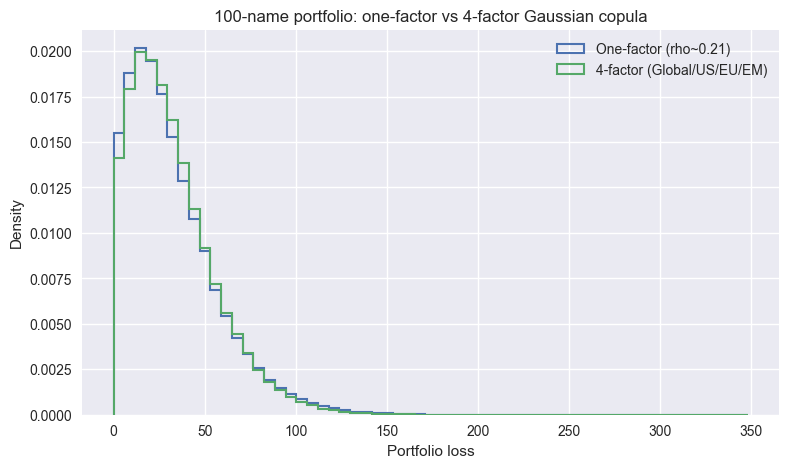

In [69]:
fig, ax = plt.subplots(figsize=(9, 5))

max_loss_large = (EAD_large * LGD_large).sum()
bins = np.linspace(0, max_loss_large, 60)

ax.hist(losses_1f, bins=bins, density=True, histtype='step', linewidth=1.5, label=f"One-factor (rho~{avg_rho:.2f})")
ax.hist(losses_nfactor, bins=bins, density=True, histtype='step', linewidth=1.5, label="4-factor (Global/US/EU/EM)")

ax.set_xlabel('Portfolio loss')
ax.set_ylabel('Density')
ax.set_title('100-name portfolio: one-factor vs 4-factor Gaussian copula')
ax.legend()
plt.show()

### 5.5 Risk measures and regional contributions

We compute EL, 99% VaR and 99% ES for both models, and examine regional loss contributions under the N‑factor model.

In [70]:
el_1f, var99_1f, es99_1f = risk_measures(losses_1f, 0.99)
el_nf, var99_nf, es99_nf = risk_measures(losses_nfactor, 0.99)

pd.DataFrame([
    {"model": "one-factor", "EL": el_1f, "VaR99": var99_1f, "ES99": es99_1f},
    {"model": "4-factor", "EL": el_nf, "VaR99": var99_nf, "ES99": es99_nf},
])

,model,EL,VaR99,ES99
0,one-factor,32.544866,112.086302,129.121016
1,4-factor,32.497804,104.921545,118.710709


Now we look at **regional loss contributions** under the 4-factor model, conditioning on losses in the top 1% tail.

In [71]:
regions_arr = portfolio_large['region'].values
unique_regions = np.unique(regions_arr)

# Identify tail scenarios for 4-factor model
var99_nf = np.quantile(losses_nfactor, 0.99)
tail_mask = losses_nfactor >= var99_nf

regional_results = []
for reg in unique_regions:
    idx = np.where(regions_arr == reg)[0]
    loss_reg_all = (defaults_nfactor[:, idx] * (EAD_large[idx] * LGD_large[idx])).sum(axis=1)
    loss_reg_tail = loss_reg_all[tail_mask]
    regional_results.append({
        'region': reg,
        'EL_region_all': loss_reg_all.mean(),
        'EL_region_tail': loss_reg_tail.mean(),
    })

pd.DataFrame(regional_results)

,region,EL_region_all,EL_region_tail
0,EM,11.199541,36.937320
1,EU,8.241465,34.822983
2,Global,0.822246,4.347422
3,US,12.234551,42.602983


The N‑factor structure lets you see which regions contribute most to overall losses, and how that changes in the tail compared with the unconditional expectation.

## 6. Modelling credit dependency with non-Gaussian copulas

The Gaussian copula is convenient, but it implies **thin tails** and **no tail dependence**: conditional on one name being in distress, the probability that others also default does not increase as strongly as we might see in real crises.

Empirically, credit spreads and default events show:
- **Asymmetric, fat-tailed dependence**: crises feature much stronger co-movements than tranquil periods.
- **Clustering of extreme losses** across regions and sectors.

Non-Gaussian copulas aim to capture this by changing the dependence structure while keeping the same marginal default probabilities.

Popular choices include:
- **Student-t copula**: symmetric fat tails, non-zero tail dependence; by far the most widely used non-Gaussian copula in credit portfolio models.
- **Clayton / Gumbel / Joe families**: asymmetric tail dependence (stronger in the left or right tail).
- **Mixtures of copulas**: combining Gaussian and t or multiple regimes for more flexibility.

Here we implement a *t-copula* analogue of the one-factor model and compare portfolio losses against the Gaussian copula with the same linear correlation.


In [72]:
import numpy as np
from scipy.stats import t as student_t

def simulate_onefactor_t_copula_defaults(n_obligors, q, rho, df, n_paths):
    """
    One-factor Student-t copula for default indicators.

    Z_i = sqrt(rho) * Y + sqrt(1-rho) * eps_i,
    where (Y, eps_i) are Student-t with df degrees of freedom,
    scaled so that Z_i have t(df) marginals.

    We then transform to uniforms via the t CDF and to defaults using q_i.
    """
    q = np.asarray(q)
    if q.shape[0] != n_obligors:
        raise ValueError("q must have length n_obligors")

    # Common factor and idios with t(df) marginals
    Y = student_t.rvs(df, size=(n_paths, 1), random_state=None)
    eps = student_t.rvs(df, size=(n_paths, n_obligors), random_state=None)

    Z = np.sqrt(rho) * Y + np.sqrt(1 - rho) * eps  # still t-like but fatter tails than Gaussian

    # Map through t CDF to uniforms
    U = student_t.cdf(Z, df)

    # Default thresholds in uniform space
    # For given target PDs q_i, default if U_i <= q_i
    defaults = U <= q
    return defaults


### 6.1 Gaussian vs t-copula for the 100-name portfolio

We keep the same marginal PDs and notionals as in the 100-name portfolio, and compare:

- One-factor **Gaussian copula** with asset correlation equal to the average systematic variance from the N-factor model.
- One-factor **t-copula** with the same rho and degrees of freedom `df = 5` (you can vary this).

We expect:
- Similar expected loss.
- **Higher tail risk** (VaR, ES) and fatter loss distribution tails under the t copula.


In [73]:
# Parameters
rho_of = float(avg_rho)   # reuse average rho from earlier
df_t = 5                  # degrees of freedom for t copula

n_paths_cop = 200_000

# Gaussian one-factor benchmark (already simulated as losses_1f, but we recompute to keep things self-contained)
defaults_gauss = simulate_gaussian_copula_defaults(n_names, q_large, rho_of, n_paths_cop)
losses_gauss = (defaults_gauss * (EAD_large * LGD_large)).sum(axis=1)

# Student-t one-factor copula
defaults_t = simulate_onefactor_t_copula_defaults(n_names, q_large, rho_of, df_t, n_paths_cop)
losses_t = (defaults_t * (EAD_large * LGD_large)).sum(axis=1)


### 6.2 Loss distributions


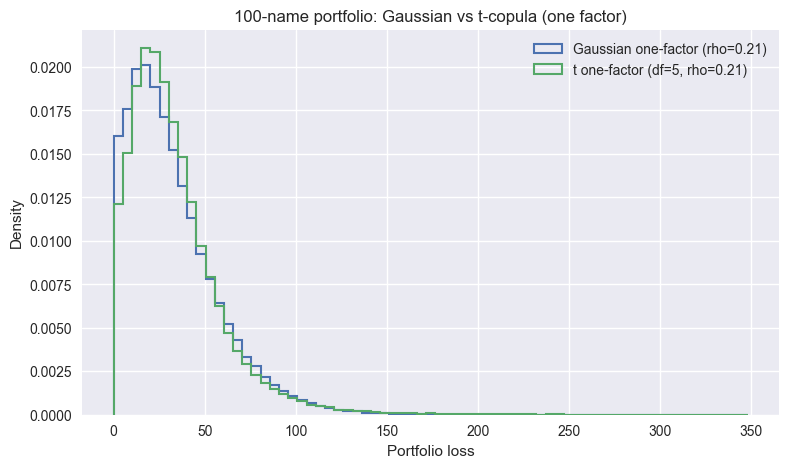

In [74]:
fig, ax = plt.subplots(figsize=(9, 5))

max_loss_large = (EAD_large * LGD_large).sum()
bins = np.linspace(0, max_loss_large, 70)

ax.hist(losses_gauss, bins=bins, density=True, histtype='step', linewidth=1.5,
        label=f"Gaussian one-factor (rho={rho_of:.2f})")
ax.hist(losses_t, bins=bins, density=True, histtype='step', linewidth=1.5,
        label=f"t one-factor (df={df_t}, rho={rho_of:.2f})")

ax.set_xlabel("Portfolio loss")
ax.set_ylabel("Density")
ax.set_title("100-name portfolio: Gaussian vs t-copula (one factor)")
ax.legend()
plt.show()


### 6.3 Risk measures comparison


In [75]:
el_g, var99_g, es99_g = risk_measures(losses_gauss, 0.99)
el_t, var99_t, es99_t = risk_measures(losses_t, 0.99)

pd.DataFrame([
    {"model": "Gaussian one-factor", "EL": el_g, "VaR99": var99_g, "ES99": es99_g},
    {"model": f"t one-factor (df={df_t})", "EL": el_t, "VaR99": var99_t, "ES99": es99_t},
])


,model,EL,VaR99,ES99
0,Gaussian one-factor,32.506006,111.268673,128.1387
1,t one-factor (df=5),33.507020,124.198029,160.1383


### 6.4 Interpretation

Key observations you will typically see in the table and plots:

- **Expected loss (EL)** is nearly identical across Gaussian and t copulas, because EL is driven mainly by the marginal default probabilities and LGDs, not by tail dependence.
- **99% VaR and ES** are higher under the t copula: extreme joint default scenarios are more frequent due to tail dependence.
- The t copula creates more **clustering of large losses**, even though the linear correlation parameter $\rho$ is held constant.

This illustrates why non-Gaussian copulas (especially the t copula) are widely used in credit portfolio models: they preserve calibration to single-name credit curves while providing a more realistic representation of systemic crisis behaviour in the portfolio tail.
